In [ ]:
from IPython.core.display import HTML
with open('./style.css') as f:
    css = f.read()
HTML(css)

<h1>Building a Tablebase</h1>

In [ ]:
import chess                                       # Simulate the chess game
import chess.gaviota                               # Load Gaviota Tablebase
from IPython.display import display, clear_output  # Better visualization and display of the chess board
import random                                      # Random moves and random creation of endgame positions
from typing import Union, List, Set                # Types to enable direct method signatures
import re     
import sqlite3
import pickle
%load_ext memory_profiler

<h2>Board representation</h2>
<div style="text-align: justify">
In order to build a large tablebase capable of storing hundreds of thousands of possible board positions, it is important to choose an effective representation of a board to store. At first, one possibility might be to store the board using the FEN-string notation, however, strings use a large amount of memory. Encoding a single board in a smaller datatype, makes it possible for us to do computations with larger datasets in memory. We do this by implementing two helper functions <b><code>board_to_int</code></b> and <b><code>int_to_board</code></b>. They enable us to encode a chess board given the current endgame as <b><code>pieces_str</code></b> as an integer and vice versa.
<br/><br/>
<h3>Encoding</h3>
<div style="text-align: justify">
The basic idea is to assign a byte within a python bytearray to each piece on the board. The value held by the byte is the position of the piece where each field is given an value between 0 and 63. The <b><code>piece_map</code></b> method within python-chess returns a dictionary containing each piece and its field. We shall use this dictionary to iterate over the chess pieces and assign the bytes. If a piece has been captured the corresponding byte will be set to <b>0xff</b>. The last byte will hold the turn information, which is stored as well as either one or zero. Finally, the resulting bytearray is encoded as a single integer and returned. 
<br/><br/>
<b>Remark:</b> Python does in fact store all integers in at least 28 bytes, which makes further optimisation of the encoding unecessary. 
</div>

In [ ]:
def board_to_int(board: chess.Board, pieces_str: str) -> int:
    piece_map = board.piece_map()
    representation = bytearray(len(pieces_str) + 1)
    for i, piece_symbol in enumerate(pieces_str):
        position_list = [pos for pos, piece in piece_map.items() if piece == chess.Piece.from_symbol(piece_symbol)]
        if not position_list: 
            representation[i] = 0xFF
        else:
            piece_map.pop(position_list[0])
            representation[i] = position_list[0]
    representation[-1] = board.turn
    return int.from_bytes(representation, 'little')

<h3>Decoding</h3>
<div style="text-align: justify">
Similarly, to decode an integer, the bytearray is transformed back into a piece mapping. The resulting dictionary can be used to initialize a new chess board. 
</div>

In [ ]:
def int_to_board(representation: int, pieces_str: str) -> chess.Board:
    board = chess.Board()
    board.clear()
    byte_representation = representation.to_bytes(len(pieces_str)+1, "little")
    mapping = dict(zip(byte_representation[:-1], [chess.Piece.from_symbol(piece_symbol) for piece_symbol in pieces_str]))
    for pos in mapping.keys():
        if pos == 0xFF: mapping.pop(pos)
    board.set_piece_map(mapping)
    board.turn = byte_representation[-1]
    return board

To demonstrate this, we will create a board from a given FEN string, encode it as an integer and then transform it back into FEN representation.

In [ ]:
fen = '3K4/8/4k3/8/8/8/8/2r5 b - - 0 1'
board = chess.Board(fen)
representation = board_to_int(board, 'Kkr')
new_board = int_to_board(representation, 'Kkr')
print(f"FEN to INT: '{fen}' -> {representation}")
print(f"INT to FEN: {representation} -> '{new_board.fen()}'")

FEN to INT: '3K4/8/4k3/8/8/8/8/2r5 b - - 0 1' -> 142395
INT to FEN: 142395 -> '3K4/8/4k3/8/8/8/8/2r5 b - - 0 1'


<h2>Retrograde Analysis</h2>
<div style="text-align: justify">
We shall use the following algorithm to calculate the depth-to-mate for every possible board within a given endgame. 
</div>
<br/><br/>
<h3>Calculating All Possible Permutations</h3>
<div style="text-align: justify">
Initially we have to calculate a set <b><code>s</code></b> containing all legal positions for a given endgame. We do this by iterating each chess piece over each chess field from 0-63. The helper function <b><code>shift_positions</code></b> takes a list containing the position of each piece on the board and will shift a single piece one field further, in order to generate the next permutation. 
</div>

In [ ]:
def shift_positions(positions: List[int]) -> List[int]:
    for i, pos in enumerate(positions[::-1]):
        if pos == 63: 
            positions[-(i+1)] = 0
            continue
        else: 
            positions[-(i+1)] += 1
            break
    return positions

If a piece has reached the end of the board, it will be set back to the beginning and increment the next piece. 

In [ ]:
shift_positions([0, 1, 63, 63])

[0, 2, 0, 0]

The <b><code>generate_s</code></b> function receives a string of pieces for which it generates the set <b><code>s</code></b> containg all legal positions. The algorithm iterates over each turn, (black and white) and further iterates over all permutations of field positions. Each permutation is mapped onto the pieces string and loaded onto a board. Next, we must check if it is a valid board using the <b><code>is_valid</code></b> method of the chess library. If so, we can encode the board as an int and add it to the set <b><code>s</code></b>. 
<br/><br/>
<b>Remark:</b> Within this function we included print statements showing the current progress as the generation process may take several minutes. This has been done for several of the following functions as well. 

In [ ]:
def generate_s(pieces_str: str) -> Set[int]:
    s = set()
    board = chess.Board()
    board.clear()
    for turn in [chess.WHITE, chess.BLACK]:
        board.turn = turn
        positions = [0] * len(pieces_str)
        while positions != [63] * len(pieces_str):
            if positions[-1] == 63 and positions[-2] == 63:
                print("\r", end="")
                print(f"{positions} -> {int(100/126*(positions[0] if turn == chess.WHITE else positions[0]+63))}%", end="")
            board.clear_board()
            mapping = dict(zip(positions, [chess.Piece.from_symbol(piece) for piece in pieces_str]))
            board.set_piece_map(mapping)
            if board.is_valid() and len(set(positions)) == len(pieces_str):
                s.add(board_to_int(board, pieces_str))
            positions = shift_positions(positions)
    return s

<h3>Calculating All Mate Positions</h3>
<div style="text-align: justify">
Next we want to calculate all positions within <b><code>s</code></b> in which the player whose turn it is, is checkmate. These positions are subtracted from the set <b><code>s</code></b> and are stored in the set <b><code>s_0</code></b>. We can easily probe for checkmate using the <b><code>is_checkmate</code></b> method of the chess library. 
</div>

In [ ]:
def generate_mate_positions(s: Set[str], pieces_str: str) -> Set[str]:
    s_0 = set()
    for i, representation in enumerate(s):
        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        if int_to_board(representation, pieces_str).is_checkmate():
            s_0.add(representation)  
    s = set(s) - s_0
    return s, s_0

<h2>The Basic Algorithm</h2>
<div style="text-align: justify">
The idea is to continue to develop the next set <b><code>s_{n+1}</code></b> and subtract them from <b><code>s</code></b> until either the next set is empyty, or <b><code>s</code></b> is empty. We will then have a series of sets <b><code>s_n</code></b> where every possible chess board position is either in one of <b><code>s_n</code></b> or in <b><code>s</code></b>. We can then define the depth-to-mate (<b>DTM</b>) value of each position as the value of <b><code>n</code></b> if a position is in the set <b><code>s_n</code></b>. This is the minimum number of moves required to force checkmate the other player (given an optimal strategy). If a position is still in <b><code>s</code></b>, the player whose turn it is can not force a checkmate on the other player in this position. 
</div>

<br>
<h3>Developing Sets With An Odd DTM</h3>
<div style="text-align: justify">
We already have <b><code>s_0</code></b>. Our next goal is to calculate all positions within <b><code>s</code></b> in which a player can reach a position within <b><code>s_0</code></b> in a single move. We will store these positions in the set <b><code>s_1</code></b>. These are positions in which the player whose turn it is can immediately checkmate the other player in his next move. 
</div>
<br>
<div style="text-align: justify">
Now we want to this for every next set <b><code>s_n</code></b> where n is odd. These are the sets in which it is the winning players turn, as he will set his opponent checkmate from a position in <b><code>s_1</code></b>. 
</div>

In [ ]:
def generate_s_odd(s: Set[str], s_prev: Set[str], pieces_str: str) -> Set[str]:
    s_next = set()
    
    for i, representation in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")
        
        board = int_to_board(representation, pieces_str)
        for move in board.legal_moves:
            board.push(move)

            if board_to_int(board, pieces_str) in s_prev:
                board.pop()
                s_next.add(board_to_int(board, pieces_str))
                break

            board.pop()

    s = set(s) - s_next
    return s, s_next

<div style="text-align: justify">
The function <b><code>generate_s_odd</code></b> takes three arguments:
<ul>
<li>The initial set <b><code>s</code></b> containing all positions which have not been placed in previous sets yet</li>
<li>The previous set <b><code>s_prev</code></b> => <code>s_{n-1}</code></li>
<li>A string <b><code>pieces_str</code></b> which contains all pieces which are currently on the board</li>
</ul>
We will then iterate over all positions in the set <b><code>s</code></b>. For each positions we will iterate over the next possible legal moves, which we can query using the built-in <b><code>.legal_moves</code></b> attribute. Each move will be applied to the current position. The resulting position will then be looked up in the previous set <b><code>s_prev</code></b>, to determine if the current move leads to a position with a lower depth-to-mate. As soon as such a position is found, we will revert the move and add the original position to our resulting set <b><code>s_next</code></b>. The algorithm will then move on to the next position in <b><code>s</code></b>. Finally, we can subtract<b><code>s_next</code></b> from <b><code>s</code></b> and return both. 
</div>
<br>
<br>
<h3>Developing Sets With An Even DTM</h3>
<div style="text-align: justify">
The next set we develop will have an even depth-to-mate value. This means, it is the turn of the player trying to defend against a checkmate. For this reason we may only place positions in this set, in which the defending player will result in a position with a lower DTM, regardless of their move. This means we are forcing the player to move closer to his checkmate. 
</div>


In [ ]:
def generate_s_even(s: Set[str], l_odd: List[Set[str]], pieces_str: str) -> Set[str]:
    s_next = set()

    for i, representation in enumerate(s):

        if i%1000 == 0: 
            print("\r", end="")
            print(f"{i}/{len(s)} -> {int((i/len(s))*100)}%", end="")

        board = int_to_board(representation, pieces_str)
        legal_moves = board.legal_moves
        
        
        fail = not legal_moves #no legal moves for stalemate position
        
        for move in legal_moves:
            board.push(move)

            if not any(board_to_int(board, pieces_str) in s_odd for s_odd in l_odd):
                fail = True
                break

            board.pop()
        
        if not fail:
            s_next.add(board_to_int(board, pieces_str))

    s = set(s) - s_next
    return s, s_next

<div style="text-align: justify">
The function <b><code>generate_s_even</code></b> takes three arguments:
<ul>
<li>The initial set <b><code>s</code></b> containing all positions which have not been placed in previous sets yet</li>
<li>A list  <b><code>l_odd</code></b> of all previous sets <b><code>s_n</code></b> where  <b><code>n</code></b> is odd.</li>
<li>A string <b><code>pieces_str</code></b> which contains all pieces which are currently on the board</li>
</ul>
We will then once again iterate over all positions in the set <b><code>s</code></b> and over each of the next possible legal moves from that position. Each move will be applied to the current position. We will then check if the move leads to at least one position in all previous sets <b><code>s_odd</code></b> in our list <b><code>l_odd</code></b>. If we find a single move for a position in which this is not true, we will not add that position to our new set <b><code>s_next</code></b> and move on to the next position. Only if we have made sure that every move leads to a lower DTM we may add the position into <b><code>s_next</code></b>. 
Finally, we can subtract<b><code>s_next</code></b> from <b><code>s</code></b> and return both. 
</div>
<br>
<b>Remark: </b> We will also make sure that we do not end in a stalemate, in which the player whose turn it is does not have any legal moves left. 
<br>
<br>
<h3>Tablebase Generation</h3>
<div style="text-align: justify">
Before we can go ahead and put it all together we have to consider how we want to store our sets. We chose the <b><code>pickle</code></b> module to write our list of sets as a single binary file to disk. 
</div>


In [ ]:
def save_sets_as_binary(list_of_sets: List[Set[int]], pieces_str: str) -> None:
    with open(f"./tables/{pieces_str}", "wb") as f:
        pickle.dump(list_of_sets, f)

<div style="text-align: justify">
The final main function will now progressively develop our series of sets. Currently we are storing all sets in memory before the function has terminated, which can take up close to 5GB of RAM for a 4-man tablebase. The execution speed varies from machine to machine, but a 3-man tablebase can be created in under 24h using the free Deepnote cloud computing service. 
</div>

In [ ]:
def main(pieces_str: str) -> None:
    
    print(f"Doing all positions")
    s = generate_s(pieces_str)
    print(f"\nLength of s = {len(s)}")
    print(f"--------------------------------------------------------------------------------------------")

    list_of_sets = []

    n = 0
    
    while True: 

        print(f"Doing s_{n}")

        if n == 0: 
            s, s_n = generate_mate_positions(s, pieces_str)
        elif n%2 == 1: 
            s, s_n = generate_s_odd(s, list_of_sets[-1], pieces_str)
        else: 
            s, s_n = generate_s_even(s, list_of_sets[1::2], pieces_str)
        
        if not s_n: break
        
        list_of_sets.append(s_n)

        print(f"\nLength of s_{n} = {len(s_n)}")
        print(f"New length of s = {len(s)}")
        print(f"--------------------------------------------------------------------------------------------")

        n += 1 

    save_sets_as_binary(list_of_sets, pieces_str)

<div style="text-align: justify">
In order to generate a tablebase we only need a string <b><code>pieces_str</code></b> specifying the pieces involved in the endgame situation. 
<br>
Initially, we will build our set <b><code>s</code></b> containing all possible board situations using our function <b><code>generate_s</code></b>. 
<br>
Then we will enter the main loop, where we shall use <b><code>n</code></b> as a counter to develop the next set <b><code>s_n</code></b>. At the start of each loop we have three cases:
<ol>
<li>In the first run, <b><code>n</code></b> will be zero. This means <b><code>s_n</code></b> and <b><code>s</code></b> will be generated using the <b><code>generate_mate_positions</code></b> function</li>
<li>If <b><code>n</code></b> is odd, we will generate <b><code>s_n</code></b> and <b><code>s</code></b> using the function <b><code>generate_s_odd</code></b> and supply the last item in our <b><code>list_of_sets</code></b> as the argument</li>
<li>If <b><code>n</code></b> is even, we will generate <b><code>s_n</code></b> and <b><code>s</code></b> using the function <b><code>generate_s_even</code></b> and supply every second item in our <b><code>list_of_sets</code></b> as the argument</li>
</ol>
At the end of each loop, we will append the calculated set <b><code>s_n</code></b> to our  <b><code>list_of_sets</code></b> and lastly increment <b><code>n</code></b>. If, however, a newly calculated set <b><code>s_n</code></b> is empty, we have found our last set and will break out of the main loop. Finally, we will store the resulting list of sets using our store function <b><code>save_sets_as_binary</code></b>
</div>

In [ ]:
main('Kknb')

Doing all positions
[63, 62, 63, 63] -> 100%
Length of s = 24536088
--------------------------------------------------------------------------------------------
Doing s_0
24536000/24536088 -> 99%
Length of s_0 = 464
New length of s = 24535624
--------------------------------------------------------------------------------------------
Doing s_1
8374000/24535624 -> 34%

<h2>Testing the Tablebase</h2>
<div style="text-align: justify">
We have now created a tablebase, which allows us to determine the depth-to-mate (DTM) for any given position af an endgame situation. Now we would like to verify our results and compare them to the Gaviota tablebase. We can do this by verifying that for every possible board position for which the Gaviota DTM equals our calculated DTM, the position is in fact stored within the correct set. Then we will also have to verify the other side: For every position in our list of sets, the Gaviota DTM must equal our calculated DTM.  
</div>

In [1]:
def test_dtm_with_gaviota(s: Set[str], test_set: Set[str], expected_dtm: int) -> None:

    with chess.gaviota.open_tablebase("./gaviota") as tablebase:

        #Check if every set in gaviota is in test set
        for rep in s:
            board = int_to_board(rep, "Kkr")
            if abs(tablebase.probe_dtm(board)) == expected_dtm:
                assert rep in test_set, f"FAILED: {board.epd()} not in test_s"

        #Check if every set in test set is in gaviota
        for rep in test_set:
            board = int_to_board(rep, "Kkr")
            gaviota_dtm = abs(tablebase.probe_dtm(board))
            assert gaviota_dtm == expected_dtm, f"FAILED: {board.epd()} -> expected_dtm ({expected_dtm}) != gaviota_dtm ({gaviota_dtm})"

NameError: name 'Set' is not defined

<div style="text-align: justify">
Our testing process makes use of the <b><code>test_dtm_with_gaviota</code></b> function. It receives three arguments:
<ul>
<li>The initial set <b><code>s</code></b> which contains all possible board postions for the given endgame</li>
<li>A set <b><code>test_set</code></b> which is the set currently under test. It contains all positions we calculated to have a specific DTM</li>
<li>The value <b><code>expected_dtm</code></b> which is the DTM we calculated for all positions within <b><code>test_set</code></b></li>
</ul>
Next we will open the Gaviota tablebase using the chess library. Both test cases will then be handled after another using assert statements. 
<br>
At the end, the function will only have run without an error if each position in <b><code>s</code></b> is in <b><code>test_set</code></b> only <b>iff</b> the Gaviota DTM of that position equals <b><code>expected_dtm</code></b>.

</div>

In [ ]:
s = generate_s("Kkr")

[62, 63, 63] -> 99%

<div style="text-align: justify">
In order to test our tablebase we first have to generate <b><code>s</code></b>, which may take a minute or two. We can then load our sets into memory using <b><code>pickle</code></b>. The code below will iterate over all sets and call the <b><code>test_dtm_with_gaviota</code></b> function for every single one. 
</div>

In [ ]:
with open('./tables/Kkr', 'rb') as f:
    list_of_sets = pickle.load(f)

for i in range(1, 33):
    exec(f"curr_set = {list_of_sets[i]}")
    test_dtm_with_gaviota(s, curr_set, i)
    print(f"s_{i} done")

s_1 done
s_2 done
s_3 done
s_4 done
s_5 done
s_6 done
s_7 done
s_8 done
s_9 done
s_10 done
s_11 done
s_12 done
s_13 done
s_14 done
s_15 done
s_16 done
s_17 done
s_18 done
s_19 done
s_20 done
s_21 done
s_22 done
s_23 done
s_24 done
s_25 done
s_26 done
s_27 done
s_28 done
s_29 done
s_30 done
s_31 done
s_32 done


In [ ]:
print(len(list_of_sets))

33


In [ ]:
with open("./tables/Kkr.txt", "r") as f:
    sets = f.readlines()
    for s_n in sets:
        exec(s_n)
    del s_n
    del sets

In [ ]:
for i in range(1, 33):
    exec(f"curr_set = s_{i}")
    test_dtm_with_gaviota(s, curr_set, i)
    print(f"s_{i} done")

s_1 done
s_2 done
s_3 done
s_4 done
s_5 done
s_6 done
s_7 done
s_8 done
s_9 done
s_10 done
s_11 done
s_12 done
s_13 done
s_14 done
s_15 done
s_16 done
s_17 done
s_18 done
s_19 done
s_20 done
s_21 done
s_22 done
s_23 done
s_24 done
s_25 done
s_26 done
s_27 done
s_28 done
s_29 done
s_30 done
s_31 done
s_32 done


In [ ]:
test_dtm_with_gaviota(s, set(), 33)

[Move.from_uci('g1h2'), Move.from_uci('g1h1'), Move.from_uci('g1f1')]


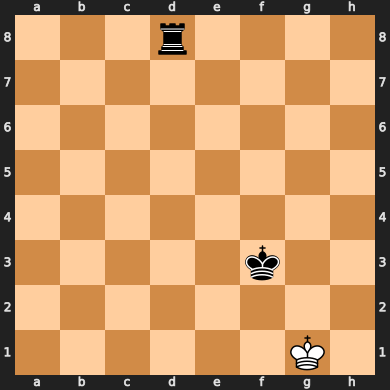

In [ ]:
b = chess.Board('3r4/8/8/8/8/5k2/8/6K1 w - -')
print(list(b.legal_moves))
b

In [ ]:
def test():
    s = set()
    for i in range(400000*64*10):
        s.add(f'3r4/8/8/8/8/5k2/8/6K1 w - {i}')

In [ ]:
import sys

In [ ]:
x = 0b1111111111111111111111111
x = int(x)
print(x)
sys.getsizeof(x)

33554431


28

In [ ]:
chess.Board().epd()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -'

In [ ]:
%%time
s = {x for x in range(25000000)}
if s & {19000000}: print("Found")
del s

Found
CPU times: user 2.25 s, sys: 1.46 s, total: 3.71 s
Wall time: 5.55 s


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6e34dfb-c85e-40db-bde6-d0ca8b0148c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>